In [4]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse



In [2]:
# for cpu user only
torch.set_num_threads(40)

In [5]:
input_path = "./snare_p0/"
output_path = "./snare_p0/scMVP_output/"
n_epochs_all = None
show_plot = True
test_mode = False

snare_p0_dataset = {
                "gene_names": 'snare_p0_scale_gene.txt',
                "gene_expression": 'snare_p0_rna_normalize_count.mtx',
                "gene_barcodes": 'snare_p0_cell_barcode.txt',
                "atac_names": 'snare_p0_peak.txt',
                "atac_expression": 'snare_p0_atac_normalize_count.mtx',
                "atac_barcodes": 'snare_p0_cell_barcode.txt'
                }
#cell_embeddings = pd.read_csv(input_path+'snare_p0_wnn_output.txt', sep="\t",index_col=None).iloc[:,[0,11]]
dataset = LoadData(dataset=snare_p0_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2021-08-11 09:12:46,106] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-08-11 09:13:14,866] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-08-11 09:13:14,947] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-08-11 09:13:14,949] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-11 09:13:17,786] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-08-11 09:13:17,823] INFO - scMVP.dataset.dataset | Downsampled from 5081 to 5081 cells


In [6]:
# atac dataloader
#dataset.atac_expression[dataset.atac_expression > 0] = np.exp(1.0)-1 # test binary peaks
atac_dataset = GeneExpressionDataset()
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
atac_dataset.populate_from_data(
    X=dataset.atac_expression, # notice the normalization
    batch_indices=None,
    gene_names=dataset.atac_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=[],
)
rna_dataset = GeneExpressionDataset()
Ys = []
measurement = CellMeasurement(
        name="atac_expression",
        data=atac_dataset.X,
        columns_attr_name="atac_names",
        columns=atac_dataset.gene_names,
    )
Ys.append(measurement)
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
rna_dataset.populate_from_data(
    X=dataset.X,
    batch_indices=None,
    gene_names=dataset.gene_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=Ys,
)

[2021-08-11 09:13:21,830] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-08-11 09:13:21,832] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-11 09:13:21,870] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-08-11 09:13:21,872] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]


### 2. 训练模型并输出

In [7]:
# 进行预训练

# model para
#n_epochs = 30 if n_epochs_all is None else n_epochs_all
lr = 5e-3
use_batches = False
use_cuda = True
n_centroids = 15
n_alfa = 1.0

# ATAC peak embedding
pre_atac_vae = VAE_Peak_SelfAttention(atac_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_atac_trainer = UnsupervisedTrainer(
    pre_atac_vae,
    atac_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/pre_atac_trainer.pkl' % output_path):
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer.pkl' % output_path))
    pre_atac_trainer.model.eval()
else:
    pre_atac_trainer.train(n_epochs=15, lr=lr)
    torch.save(pre_atac_trainer.model.state_dict(), '%s/pre_atac_trainer.pkl' % output_path)
    pre_atac_trainer.model.eval()


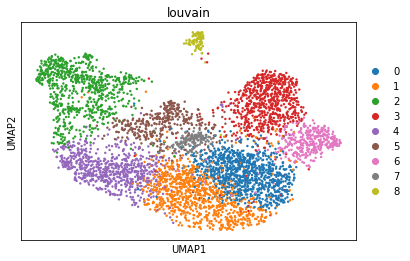

In [7]:

# ATAC pretrainer_posterior:
full = pre_atac_trainer.create_posterior(pre_atac_trainer.model, atac_dataset, indices=np.arange(len(atac_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
prior_adata = anndata.AnnData(X=atac_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()



### RNA预训练

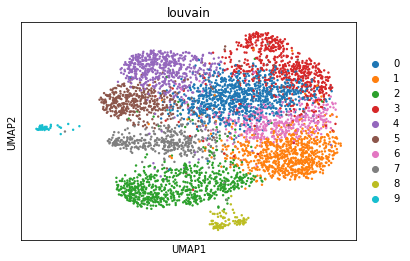

In [8]:
# RNA embedding
pre_vae = VAE_Attention(rna_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/pre_trainer.pkl' % output_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer.pkl' % output_path))
    pre_trainer.model.eval()

else:
    pre_trainer.train(n_epochs=10, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer.pkl' % output_path)
    pre_trainer.model.eval()

# RNA pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, rna_dataset, indices=np.arange(len(rna_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

df = pd.DataFrame(data=imputed_values.T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
#df.to_csv(os.path.join(save_path,"gene_scvi_imputation_210324_2.csv"))
# visulization
prior_adata = anndata.AnnData(X=rna_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
#matplotlib.use('TkAgg')
#fig, ax = plt.subplots(figsize=(7, 6))
#sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)
#plt.show()
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()


### multivae训练


In [9]:
n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(rna_dataset.nb_genes, len(rna_dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/multi_vae_trainer.pkl' % output_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_trainer.pkl' % output_path))
    trainer.model.eval()
else:
    pre_trainer = UnsupervisedTrainer(
        pre_vae,
        rna_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer.pkl' % output_path))

    pre_atac_trainer = UnsupervisedTrainer(
        pre_atac_vae,
        atac_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer.pkl' % output_path))

    n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

    # joint RNA and ATAC embedding
    trainer.model.init_gmm_params_with_louvain(latent,np.array(prior_adata.obs['louvain'].tolist()).astype(int))

    trainer.model.RNA_encoder.load_state_dict(pre_trainer.model.z_encoder.state_dict())
    for param in trainer.model.RNA_encoder.parameters():
        param.requires_grad = True
    trainer.model.ATAC_encoder.load_state_dict(pre_atac_trainer.model.z_encoder.state_dict())
    for param in trainer.model.ATAC_encoder.parameters():
        param.requires_grad = True
    trainer.train(n_epochs=15, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer.pkl' % output_path)
    trainer.model.eval()

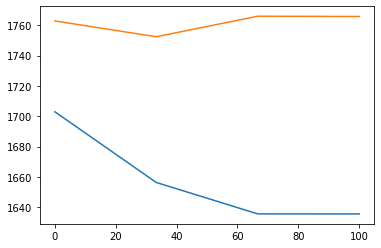

In [10]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 100, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()


... storing 'cell_type' as categorical


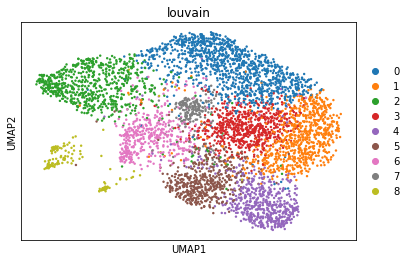

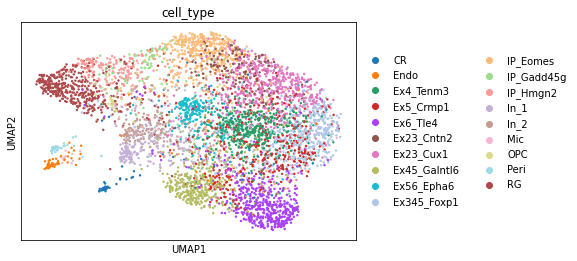

In [11]:
# 输出模型结果
# posterior

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
# visulization
prior_adata = anndata.AnnData(X=latent)
prior_adata.obsm["X_multi_vi"] = latent
cell_embeddings = pd.read_csv(input_path+'snare_p0_wnn_output.txt', sep="\t",index_col=0).iloc[:,[5,12]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list()
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

... storing 'cell_type' as categorical


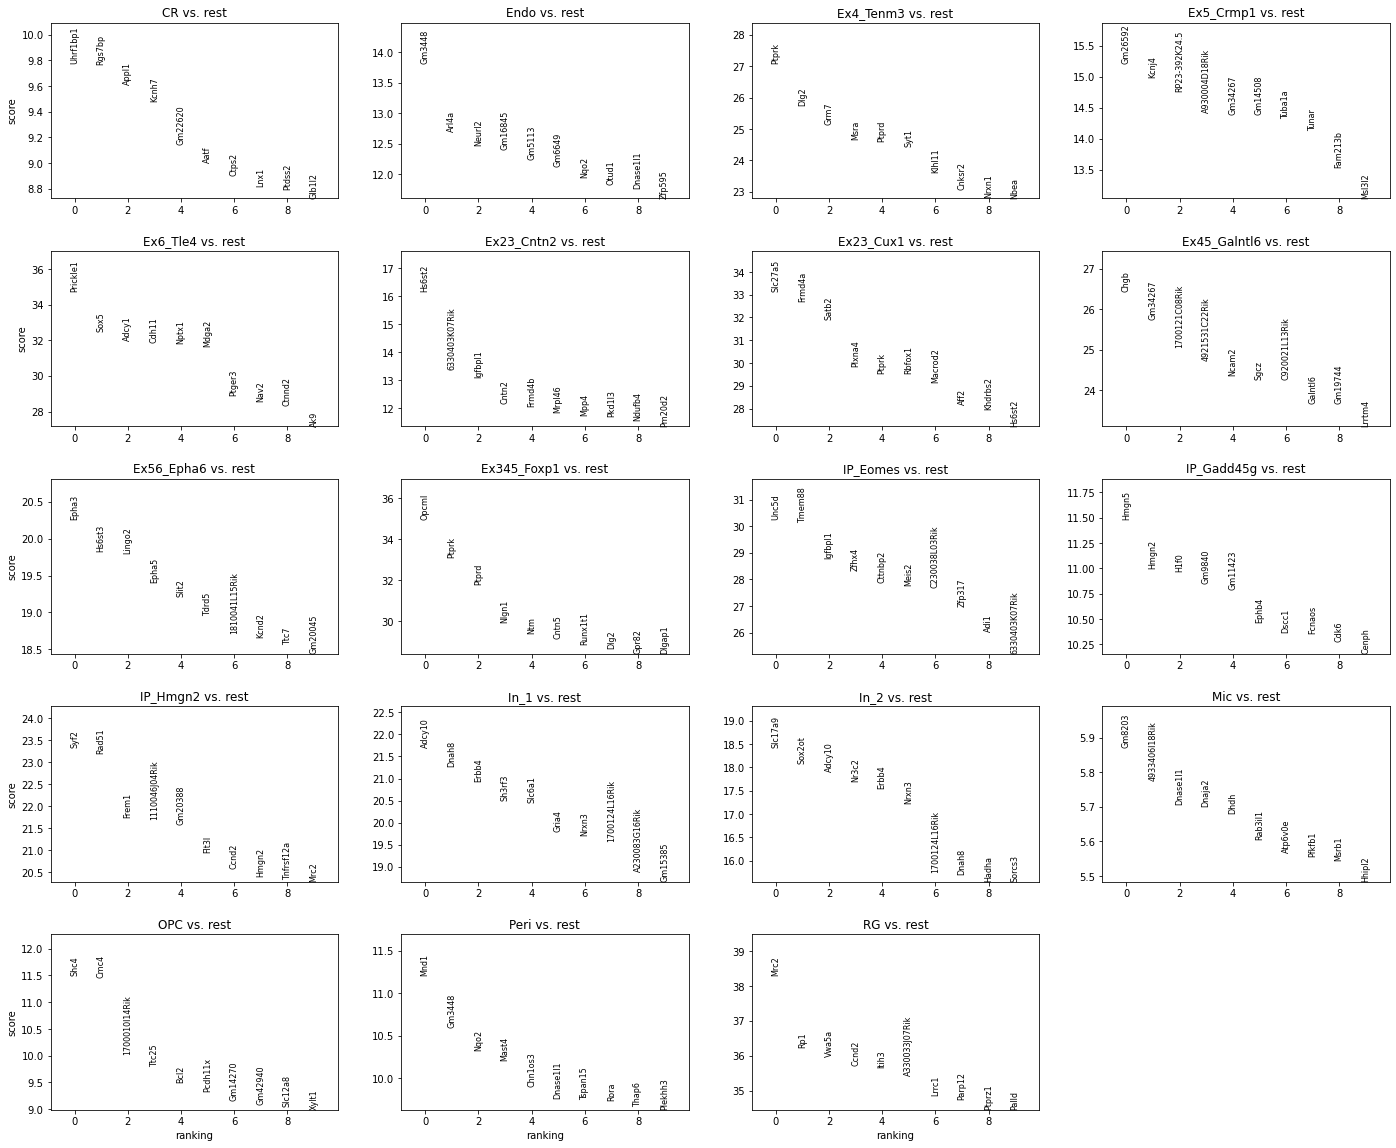

In [40]:
posterior_adata = anndata.AnnData(X=imputed_values[0])
posterior_adata.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list()
sc.tl.rank_genes_groups(posterior_adata, 'cell_type')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
df_tmp=sc.get.rank_genes_groups_df(posterior_adata, group=np.unique(cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list())[0])
df_tmp["group"] = np.unique(cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list())[0]
df_tab=df_tmp
for index in [np.unique(cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list())[i] for i in range(1,19)]:
    df_tmp=sc.get.rank_genes_groups_df(posterior_adata, group=str(index))
    df_tmp["group"] = index
    df_tab = pd.concat([df_tab,df_tmp],axis=0)
    
df_tab.to_csv("{}/snare_p0_DEG.csv".format(output_path),index=False)


In [12]:

# save file
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=rna_dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=rna_dataset.barcodes)
df.insert(0,"louvain",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"multivae_umap.csv"))

df = pd.DataFrame(data=imputed_values[1].T, columns=rna_dataset.barcodes, index=rna_dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation.csv"))


df = pd.DataFrame(data=imputed_values[0].T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
df.to_csv(os.path.join(output_path,"gene_multivae_imputation.csv"))


In [14]:

def binarization(imputed, raw):
    return (imputed > np.quantile(imputed_values[1].reshape(-1),q=0.9)).astype(np.int8)

atac_binary=binarization(imputed_values[1],dataset.atac_expression)
df = pd.DataFrame(data=atac_binary.T, columns=rna_dataset.barcodes, index=rna_dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation_binary.csv"))

In [35]:
# compute scvi deg
scvi_impute_tab=pd.read_csv("../../appeal/snare_p0/scMVP_output/gene_scvi_imputation.csv", sep=",",index_col=0)

... storing 'cell_type' as categorical


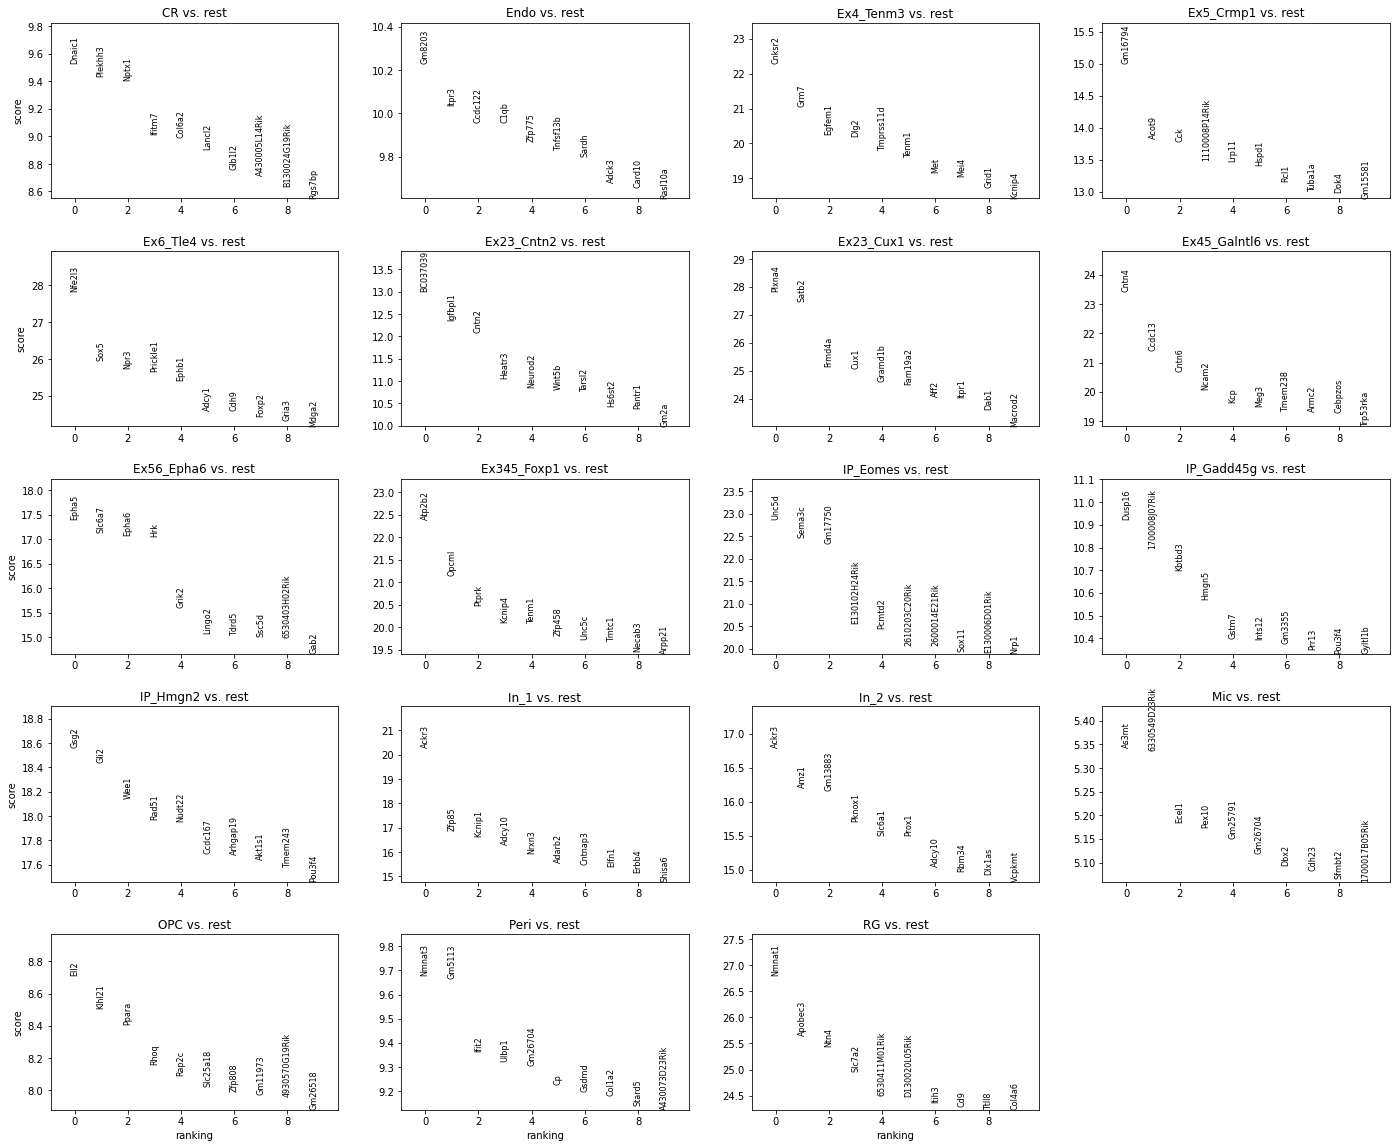

In [44]:
posterior_adata = anndata.AnnData(X=scvi_impute_tab.T)
posterior_adata.var = pd.DataFrame(index=scvi_impute_tab.index.values)
# posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] = cell_embeddings.loc[scvi_impute_tab.columns.values,"IdentChar"].to_list()
sc.tl.rank_genes_groups(posterior_adata, 'cell_type')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
df_tmp=sc.get.rank_genes_groups_df(posterior_adata, group=np.unique(cell_embeddings.loc[scvi_impute_tab.columns.values,"IdentChar"].to_list())[0])
df_tmp["group"] = np.unique(cell_embeddings.loc[scvi_impute_tab.columns.values,"IdentChar"].to_list())[0]
df_tab=df_tmp
for index in [np.unique(cell_embeddings.loc[scvi_impute_tab.columns.values,"IdentChar"].to_list())[i] for i in range(1,19)]:
    df_tmp=sc.get.rank_genes_groups_df(posterior_adata, group=str(index))
    df_tmp["group"] = index
    df_tab = pd.concat([df_tab,df_tmp],axis=0)
    
df_tab.to_csv("{}/snare_p0_scvi_DEG.csv".format(output_path),index=False)